In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import onnxruntime as ort
import utils

---
##### Load the ONNX model


In [2]:
save_path = '../onnx_models_cuda'

In [3]:
def load_session(path, provider = 'cuda'):
    if provider == 'cuda':
        return ort.InferenceSession(path, providers=['AzureExecutionProvider'])
    else:
        return ort.InferenceSession(path)

- Text Encoder

In [4]:
sessTokenizer       = load_session(f'{save_path}/tokenizer/to_quant.onnx')
sessionTextEncoder  = load_session(f'{save_path}/text_encoder/te_quant.onnx')

- Denoising

In [5]:
sessUNetPre     = load_session(f'{save_path}/unet/upre_quant.onnx')
sessUNetDown    = load_session(f'{save_path}/unet/udown_quant.onnx')
sessUNetMid     = load_session(f'{save_path}/unet/umid_quant.onnx')
sessUNetUp00    = load_session(f'{save_path}/unet/uup-0_quant.onnx')
sessUNetUp10    = load_session(f'{save_path}/unet/uup-1_quant.onnx')
sessUNetUp20    = load_session(f'{save_path}/unet/uup-2_quant.onnx')
sessUNetUp30    = load_session(f'{save_path}/unet/uup-3-0_quant.onnx')
sessUNetUp31    = load_session(f'{save_path}/unet/uup-3-1_quant.onnx')
sessUNetUp32    = load_session(f'{save_path}/unet/uup-3-2_quant.onnx')
sessUNetPost    = load_session(f'{save_path}/unet/upost_quant.onnx')

- Schedulers

In [25]:
sessScheduler981     = load_session(f'{save_path}/scheduler_2/sche981_quant.onnx')
sessScheduler9611    = load_session(f'{save_path}/scheduler_2/sche9611_quant.onnx')
sessScheduler9612    = load_session(f'{save_path}/scheduler_2/sche9612_quant.onnx')
sessScheduler941     = load_session(f'{save_path}/scheduler_2/sche941_quant.onnx')
sessSchedulerNN      = load_session(f'{save_path}/scheduler_2/scheNN_quant.onnx')

- Decoder

In [7]:
sessDecoder      = load_session(f'{save_path}/decoder/de_quant.onnx')

---
Main

In [8]:
device = "cpu"
dtype = torch.float32

- Text Input 👉 Text Embedding

In [9]:
ascii_str   = utils.toAsciiTensor()
text_ids = sessTokenizer.run(None, {
    'input' : ascii_str.detach().cpu().numpy()
})[0]
print(text_ids.shape)
print(text_ids)

(1, 77)
[[49407   320  3490  2368 49406     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]


In [10]:
embed = sessionTextEncoder.run(None, {
    'input' : text_ids
})[0]

👉 Denosing

In [46]:
timesteps = [
    981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761,
    741, 721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501,
    481, 461, 441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241,
    221, 201, 181, 161, 141, 121, 101,  81,  61,  41,  21,   1
]
latents0 = torch.randn([1,4,64,64], dtype= dtype, device = device)
extra_step_kwargs = {}

In [12]:
sessUpList  = [sessUNetUp00, sessUNetUp10, sessUNetUp20]
up_3_list   = [sessUNetUp30, sessUNetUp31, sessUNetUp32]

def forward_UNet(
    x,          # x : [1 4 64 64]
    t,          # t : [1]
    text_embed  # text_embed : [2 77 768]
):
    #* Pre
    output = sessUNetPre.run(None, {
        sessUNetPre.get_inputs()[0].name: x,
    })[0]
    #* Down
    outputs = sessUNetDown.run(None, {
        sessUNetDown.get_inputs()[0].name: output,
        sessUNetDown.get_inputs()[1].name: t,
        sessUNetDown.get_inputs()[2].name: text_embed
    })
    sample, emb, down_block_res_samples = outputs[0], outputs[1], outputs[2:]
    #* Mid
    outputs = sessUNetMid.run(None, {
        sessUNetMid.get_inputs()[0].name: sample,
        sessUNetMid.get_inputs()[1].name: emb,
        sessUNetMid.get_inputs()[2].name: text_embed
    })
    sample = outputs[0]
    #* Up
    for i in range(3):
        res_samples = down_block_res_samples[-3 :]
        down_block_res_samples = down_block_res_samples[: -3]
        if i == 0:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: res_samples[0],
                sessUpList[i].get_inputs()[3].name: res_samples[1],
                sessUpList[i].get_inputs()[4].name: res_samples[2],
            })
            sample = outputs[0]
            # print(sample.shape)
        else:
            outputs = sessUpList[i].run(None, {
                sessUpList[i].get_inputs()[0].name: sample,
                sessUpList[i].get_inputs()[1].name: emb,
                sessUpList[i].get_inputs()[2].name: text_embed,
                sessUpList[i].get_inputs()[3].name: res_samples[0],
                sessUpList[i].get_inputs()[4].name: res_samples[1],
                sessUpList[i].get_inputs()[5].name: res_samples[2],
            })
            sample = outputs[0]          
    for i in range(3):
        outputs = up_3_list[i].run(None, {
            up_3_list[i].get_inputs()[0].name: sample,
            up_3_list[i].get_inputs()[1].name: emb,
            up_3_list[i].get_inputs()[2].name: text_embed,
            up_3_list[i].get_inputs()[3].name: down_block_res_samples[-(i+1)],
        })
        sample = outputs[0]
    outputs = sessUNetPost.run(None,{
            sessUNetPost.get_inputs()[0].name: sample,
    })
    sample = outputs[0]
    # print(sample.shape)
    return sample#, x

In [34]:
from diffusers import DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32).to(device)

Couldn't connect to the Hub: 401 Client Error. (Request ID: Root=1-66e5e3b4-47ef9b081eebc585535f9a0f;1b910394-201b-41c9-8454-2c0d11eb7376)

Repository Not Found for url: https://huggingface.co/api/models/runwayml/stable-diffusion-v1-5.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password..
Will try to load from local cache.


In [56]:
pipeline.scheduler.set_timesteps(50, device=device)
timesteps = pipeline.scheduler.timesteps
ets = []
latents = latents0.clone().detach().numpy()
for idx, t in enumerate(timesteps):
    timestep = torch.tensor([t], dtype = dtype, device = device).detach().numpy()
    # (1) UNet
    latents = torch.tensor(latents)
    latent_model_input = torch.cat([latents] * 2).to(device = device)
    latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t).to(device = device)
    noise_pred = pipeline.unet(
        latent_model_input.to(device = device),
        t,
        encoder_hidden_states=torch.tensor(embed).to(device = device),
        cross_attention_kwargs=None,
        return_dict=False,
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
    noise_pred  = noise_pred.detach().numpy()
    latents     = latents.detach().numpy()
    # noise_pred = forward_UNet(
    #     x = latents, 
    #     t = torch.tensor([t], dtype = dtype, device = device).detach().numpy(), 
    #     text_embed = embed
    # )
    
    # (2) Scheduler.step
    if t == 981:
        ets.append(noise_pred)
        cur_output = latents
        ort_outputs = sessScheduler981.run(None, {
            'model_output' : noise_pred,
            'sample'       : latents,  
        })#[0]
    
    elif t == 961 and idx == 1:
        latents = sessScheduler9611.run(None, {
            'model_output'  : noise_pred,
            # 'sample'        : latents,
            'cur_sample'    : cur_output,
            'ets0'          : ets[0]
        })[0]
        cur_output = None
    
    elif t == 961 and idx == 2: 
        latents = sessScheduler9612.run(None, {
            'model_output'  : noise_pred,
            'sample'        : latents,
            'ets0'          : ets[0]
        })[0]
        ets.append(noise_pred)
    
    elif t == 941:
        latents = sessScheduler941.run(None, {
            'model_output'  : noise_pred,
            'sample'        : latents,
            'ets0'          : ets[0],
            'ets1'          : ets[1]
        })[0]
        ets.append(noise_pred)
    
    else:
        latents = sessSchedulerNN.run(None, {
            'model_output'  : noise_pred,
            'timestep'      : torch.tensor([t], dtype = torch.int64, device = device).detach().numpy(),
            'prev_timestep' : torch.tensor([t-20], dtype = torch.int64, device = device).detach().numpy(),
            'sample'        : latents,
            'ets0'          : ets[0],        
            'ets1'          : ets[1],
            'ets2'          : ets[2]
        })[0]
        ets = ets[-3:]
        ets.append(noise_pred)
    # latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
    
    print(t, end=' ➭ ' if (idx%10 != 0 and idx!= 0) else ' ➭ \n')

981 ➭ 
961 ➭ 961 ➭ 941 ➭ 921 ➭ 901 ➭ 881 ➭ 861 ➭ 841 ➭ 821 ➭ 801 ➭ 
781 ➭ 761 ➭ 741 ➭ 721 ➭ 701 ➭ 681 ➭ 661 ➭ 641 ➭ 621 ➭ 601 ➭ 
581 ➭ 561 ➭ 541 ➭ 521 ➭ 501 ➭ 481 ➭ 461 ➭ 441 ➭ 421 ➭ 401 ➭ 
381 ➭ 361 ➭ 341 ➭ 321 ➭ 301 ➭ 281 ➭ 261 ➭ 241 ➭ 221 ➭ 201 ➭ 
181 ➭ 161 ➭ 141 ➭ 121 ➭ 101 ➭ 81 ➭ 61 ➭ 41 ➭ 21 ➭ 1 ➭ 


---
### Decoder

In [48]:
from PIL import Image
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images

In [59]:
output = sessDecoder.run(None, {
    'input': latents#.detach().numpy()
})[0]

In [53]:
output[0].shape

(512, 512, 3)

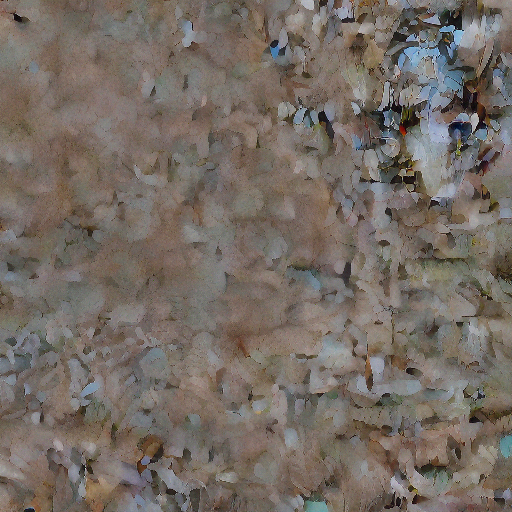

In [60]:
img = numpy_to_pil(output[0])
img[0].show()